# LogGamma

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from six.moves import range

# system functions that are always useful to have
import time, sys, os
import warnings

# basic numeric setup
import numpy as np

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(1028)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

The multi-modal LogGamma distribution is useful for stress testing the effectiveness of bounding distributions. It is defined as:

$$ 
g_a \sim \textrm{LogGamma}(1, 1/3, 1/30) \\
g_b \sim \textrm{LogGamma}(1, 2/3, 1/30) \\
n_c \sim \textrm{Normal}(1/3, 1/30) \\
n_d \sim \textrm{Normal}(2/3, 1/30) \\
d_i \sim \textrm{LogGamma}(1, 2/3, 1/30) ~\textrm{if}~ i \leq \frac{d+2}{2} \\
d_i \sim \textrm{Normal}(2/3, 1/30) ~\textrm{if}~ i > \frac{d+2}{2} \\
\mathcal{L}_g = \frac{1}{2} \left( g_a(x_1) + g_b(x_1) \right) \\
\mathcal{L}_n = \frac{1}{2} \left( n_a(x_2) + n_d(x_2) \right) \\
\ln \mathcal{L} \equiv \ln \mathcal{L}_g + \ln \mathcal{L}_n + \sum_{i=3}^{d} \ln d_i(x_i)
$$

In [4]:
from scipy.stats import loggamma, norm

def lng(x):
    lng1 = loggamma.logpdf(x[0], c=1., loc=1./3., scale=1./30.)
    lng2 = loggamma.logpdf(x[0], c=1., loc=2./3., scale=1./30.)
    
    return np.logaddexp(lng1, lng2) + np.log(0.5)

def lnn(x):
    lnn1 = norm.logpdf(x[1], loc=1./3., scale=1./30.)
    lnn2 = norm.logpdf(x[1], loc=2./3., scale=1./30.)
    
    return np.logaddexp(lnn1, lnn2) + np.log(0.5)

def lnd_i(x_i, i):
    if i >= 3:
        if i <= (ndim + 2) / 2.:
            return loggamma.logpdf(x_i, c=1., loc=2./3., scale=1./30.)
        else:
            return norm.logpdf(x_i, loc=2./3., scale=1./30.)
    else:
        return 0.
    
def lnd(x):
    return sum([lnd_i(x_i, i) for i, x_i in enumerate(x)])
    
def loglike(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return lng(x) + lnn(x) + lnd(x)

# define the prior transform
def prior_transform(x):
    return x

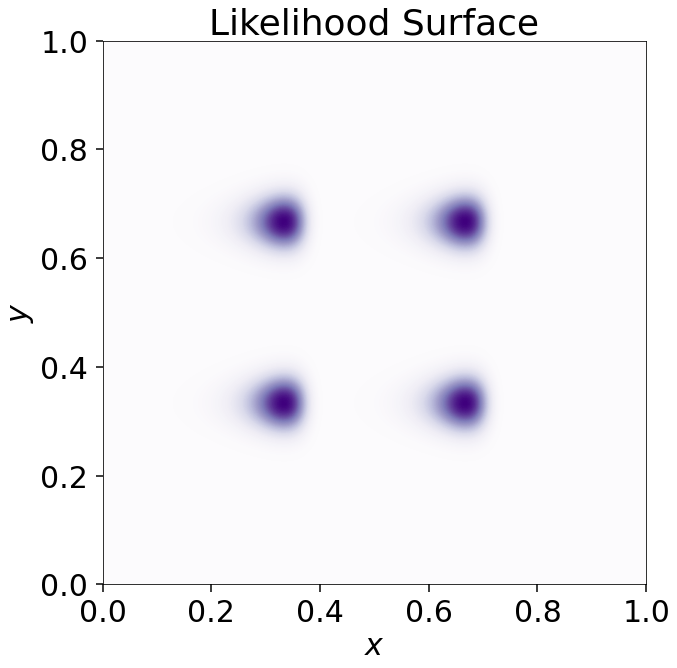

In [5]:
# plot the log-likelihood surface
plt.figure(figsize=(10., 10.))
axes = plt.axes(aspect=1)
xx, yy = np.meshgrid(np.linspace(0., 1., 200),
                     np.linspace(0., 1., 200))
logL = np.array([loglike(np.array([x, y]))
                 for x, y in zip(xx.flatten(), yy.flatten())])
L = np.exp(logL.reshape(xx.shape))
axes.contourf(xx, yy, L, 200, cmap=plt.cm.Purples)
plt.title('Likelihood Surface')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

We will now sample from this distribution using `'multi'` and `'rslice'` in $d=2$ and $d=10$ dimensions.

In [6]:
ndim = 2
nlive = 250
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim,
                                bound='multi', sample='rwalk',
                                walks=100, nlive=nlive, rstate=rstate)
sampler.run_nested(dlogz=0.01)
res = sampler.results

2016it [08:00,  4.20it/s, +250 | bound: 31 | nc: 1 | ncall: 124105 | eff(%):  1.830 | loglstar:   -inf <  3.497 <    inf | logz:  0.062 +/-  0.098 | dlogz:  0.000 >  0.010]


In [7]:
ndim = 10
nlive = 250
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim, 
                                bound='multi', sample='rwalk',
                                walks=100, nlive=nlive, rstate=rstate)
sampler.run_nested(dlogz=0.01)
res2 = sampler.results

6237it [43:58,  2.36it/s, +250 | bound: 142 | nc: 1 | ncall: 543318 | eff(%):  1.195 | loglstar:   -inf < 20.288 <    inf | logz: -0.002 +/-  0.252 | dlogz:  0.000 >  0.010]


Our analytic approximations to the error appear to have diverged, so let's compute them numerically:

In [8]:
from dynesty import utils as dyfunc
from dynesty.results import Results

# compute ln(evidence) error for d=2 case
logzs = np.zeros((100, len(res.logvol)))
for i in range(100):
    r = dyfunc.simulate_run(res, approx=True)
    logzs[i] = np.interp(-res.logvol, -r.logvol, r.logz)
logzerr = np.std(logzs, axis=0)
dres = res.asdict()
dres['logzerr'] = logzerr
res = Results(dres)

# compute ln(evidence) error for d=10 case
logzs2 = np.zeros((100, len(res2.logvol)))
for i in range(100):
    r = dyfunc.simulate_run(res2, approx=True)
    logzs2[i] = np.interp(-res2.logvol, -r.logvol, r.logz)
logzerr2 = np.std(logzs2, axis=0)
dres2= res2.asdict()
dres2['logzerr'] = logzerr2
res2 = Results(dres2)

Now let's see how we did!

/home/koposov/pyenv38/lib/python3.8/site-packages/dynesty/plotting.py:294: RuntimeWarning: overflow encountered in exp
  np.exp(logz + s * logzerr),


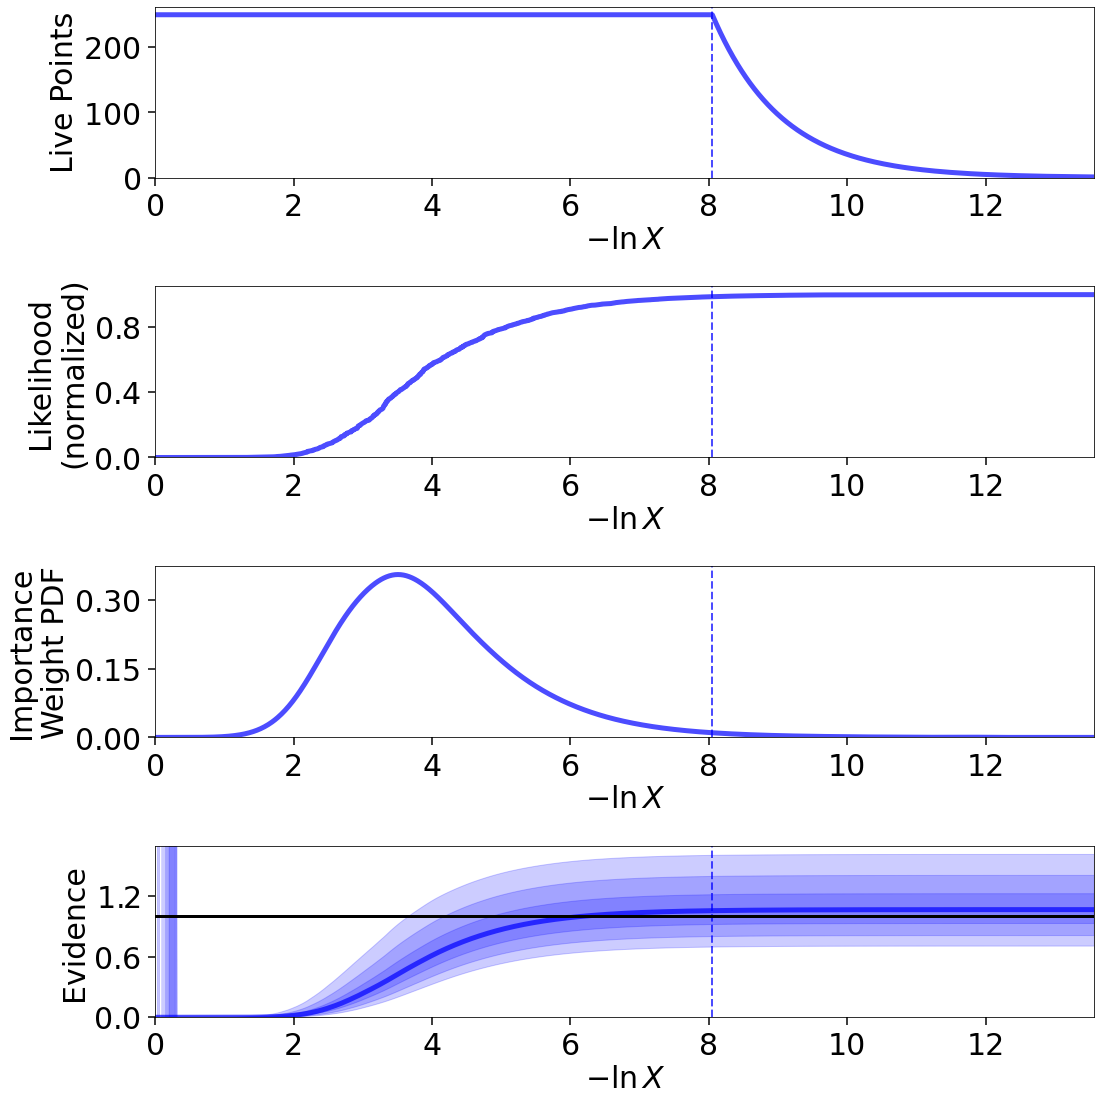

In [9]:
from dynesty import plotting as dyplot

# plot 2-D
fig, axes = dyplot.runplot(res, color='blue',
                           lnz_truth=0., truth_color='black')
fig.tight_layout()

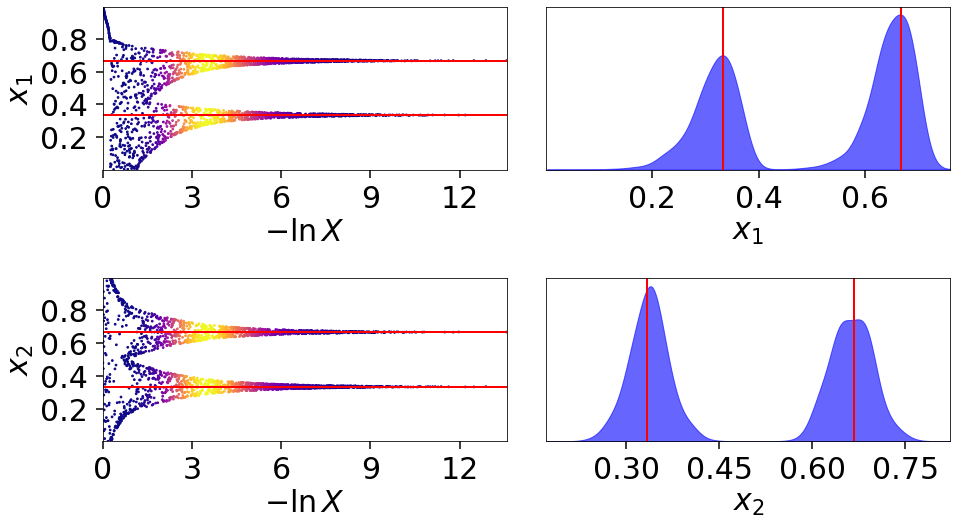

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig, axes = dyplot.traceplot(res, truths=[[1./3., 2./3.], [1./3., 2./3.]],
                             quantiles=None, fig=(fig, axes))
fig.tight_layout()

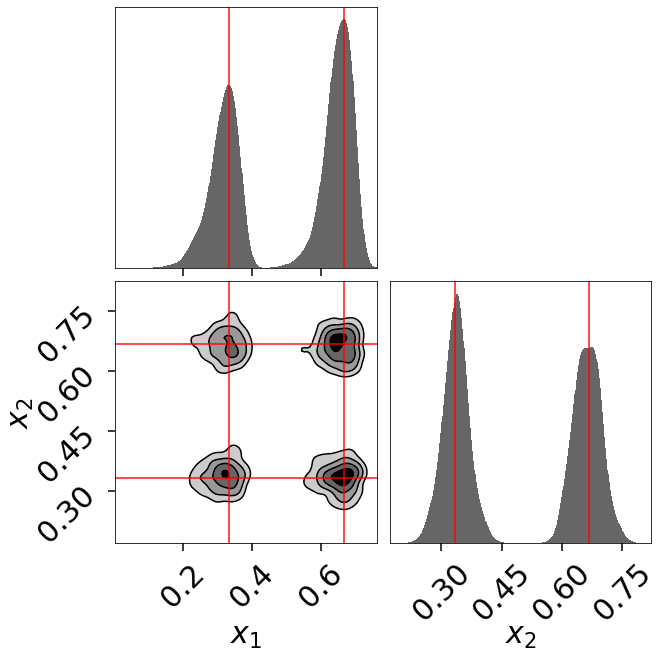

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig, axes = dyplot.cornerplot(res, truths=[[1./3., 2./3.], [1./3., 2./3.]],
                              quantiles=None, fig=(fig, axes))

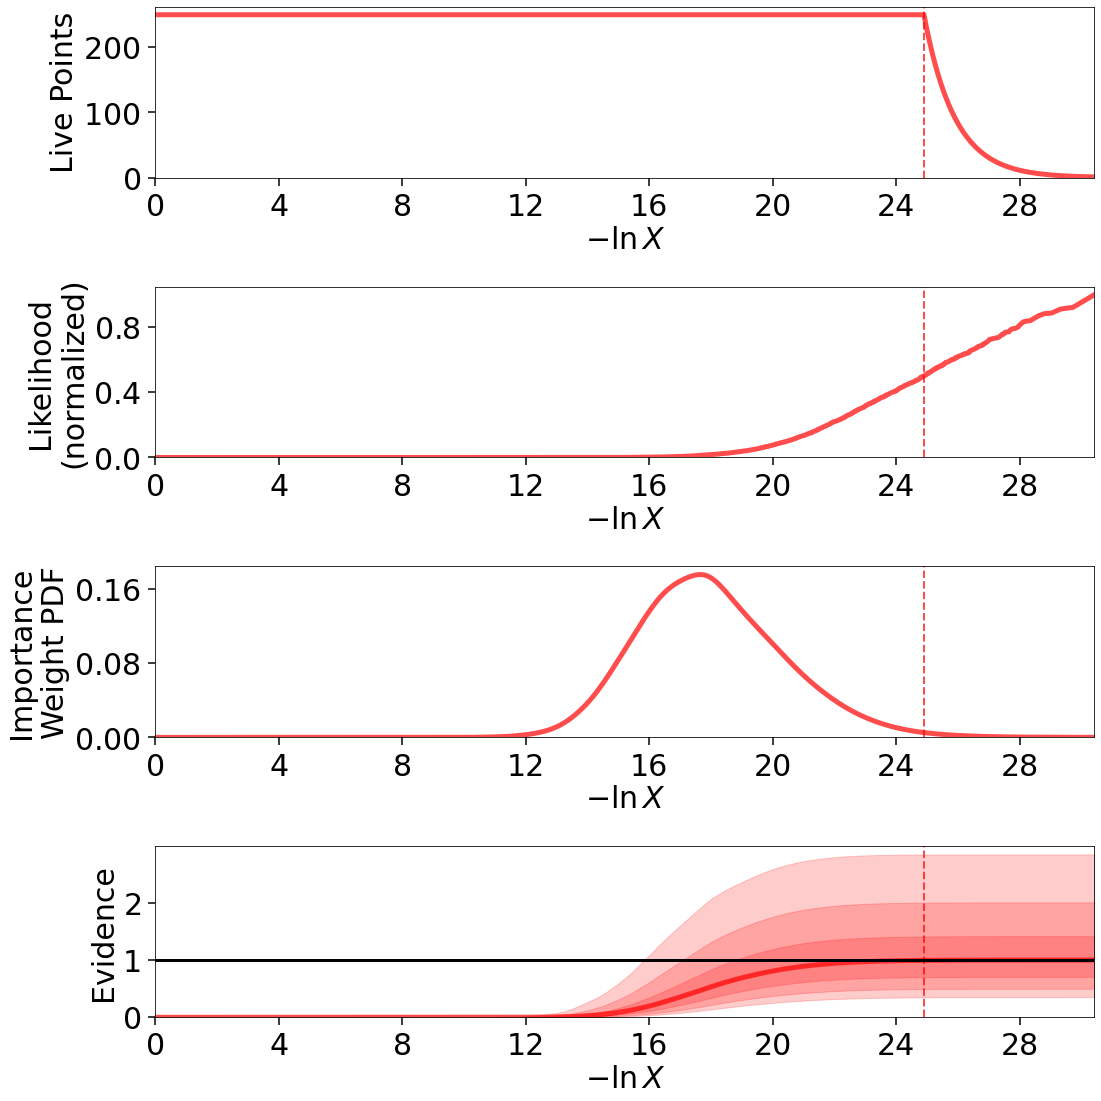

In [12]:
# plot 10-D
fig, axes = dyplot.runplot(res2, color='red', 
                           lnz_truth=0., truth_color='black')
fig.tight_layout()

It looks like our results are unbiased with respect to the true log-evidence and we properly recover the components of the distribution.